# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [2]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = 'data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')

#log1p,=log(x+1) 即ln(x+1)，壓縮數據到一個區間的同時，也提高值的精確度(*np.log(1 + 1e-99)=0.0，np.log1p(1e-99)=1e-99)
train_Y = np.log1p(df_train['SalePrice'])
df = df_train.drop(['Id', 'SalePrice'] , axis=1)#drop：刪除表中特定欄位。drop函数默认删除行，列需要加axis
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)#把feature裡的值放進num_features
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [6]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)#缺失數據用'-1'填補
MMEncoder = MinMaxScaler() #將數據縮放至給定的最小值與最大值之間，通常是０與１之間。
train_num = train_Y.shape[0] #查看矩陣或者數組的維數。
#c.shape[1] 为第一维的长度，c.shape[0] 为第二维的长度。ex:
#>>> c = array([[1,1],[1,2],[1,3],[1,4]])
#>>> c.shape
#(4, 2)
#>>> c.shape[0]
#4
#>>> c.shape[1]
#2
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

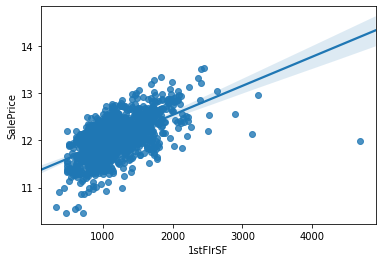

0.846643681071632

In [7]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = df['1stFlrSF'][:train_num], y=train_Y) #繪製數據和線性回歸模型的關係。((不太懂
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df) #fit_transform：先計算均值和標準差再轉換。每一個transform都需要先fit,比如把數據轉為（0，1）分佈，需要均值和標準差。
estimator = LinearRegression()#是在資料點中找出規律、畫出一條直線(最符合此資料走向的一條線性'linear'的線)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()#使用不同的資料組合來驗證你訓練的模型。.mean()對這些資料做平均值計算。
#參數:estimator：所調用的機器學習模型算法 X:訓練集 y：訓練集的目標值 scoring:評測模型的打分標準->cv:交叉驗證分割樣本集的策略，默認是3折交叉驗證。

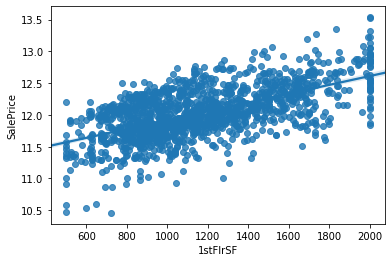

0.876580486010791

In [8]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
#Me:將範圍限制在 500 到 2000
"""
Your Code Here
"""
df['1stFlrSF'] = df['1stFlrSF'].clip(500, 2000)#.clip(a_min, a_max)：將數組中的元素限制在a_min, a_max之間，大於a_max的就使得它等於 a_max，小於a_min,的就使得它等於a_min。
sns.regplot(x = df['1stFlrSF'], y=train_Y)#繪製數據和線性回歸模型的關係。
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。

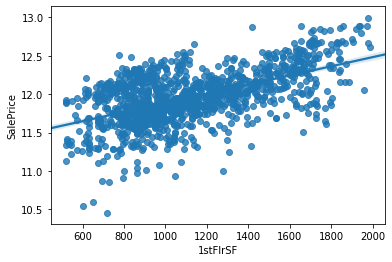

0.8607646459127191

In [11]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
#Me:將範圍限制在 500 到 2000
"""
Your Code Here
"""
#限制範圍but不像cilp依樣(會把 >500 跟 <2000 的算成 500 & 2000)
#用此方法會直接捨離群值
keep_indexs = (df['1stFlrSF']> 500) & (df['1stFlrSF']< 2000) 
#keep_indexs = 500 < df['1stFlrSF'] < 2000 #erro:The truth value of a Series is ambiguous.
df = df[keep_indexs]
train_Y = train_Y[keep_indexs]
sns.regplot(x = df['1stFlrSF'], y=train_Y)#繪製數據和線性回歸模型的關係。
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()